<a href="https://colab.research.google.com/github/repairedserver/Test/blob/master/%EC%88%9C%ED%99%98%EC%8B%A0%EA%B2%BD%EB%A7%9D(RNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [64]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [65]:
cd/content/gdrive/My Drive/deeplearningbro/deeplearningbro/pytorch

/content/gdrive/My Drive/deeplearningbro/deeplearningbro/pytorch


In [66]:
df = pd.read_csv("./data/kospi.csv") #주식 데이따

In [67]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-30,2183.489990,2206.199951,2177.879883,2206.199951,2206.199951,480400
1,2019-01-31,2222.879883,2222.879883,2201.219971,2204.850098,2204.850098,545200
2,2019-02-01,2211.929932,2218.780029,2201.409912,2203.459961,2203.459961,479400
3,2019-02-07,2215.770020,2215.790039,2196.770020,2203.419922,2203.419922,427800
4,2019-02-08,2192.010010,2192.479980,2171.959961,2177.050049,2177.050049,391000


In [68]:
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close', 'Volume']])

In [69]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-30,0.722898,0.732351,0.745525,0.759235,2206.199951,0.242113
1,2019-01-31,0.763058,0.750069,0.769089,0.757866,2204.850098,0.274771
2,2019-02-01,0.751894,0.745714,0.769280,0.756456,2203.459961,0.241609
3,2019-02-07,0.755809,0.742538,0.764596,0.756415,2203.419922,0.215603
4,2019-02-08,0.731584,0.717777,0.739548,0.729669,2177.050049,0.197057


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431 entries, 0 to 430
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       431 non-null    object 
 1   Open       431 non-null    float64
 2   High       431 non-null    float64
 3   Low        431 non-null    float64
 4   Close      431 non-null    float64
 5   Adj Close  431 non-null    float64
 6   Volume     431 non-null    float64
dtypes: float64(6), object(1)
memory usage: 23.7+ KB


In [71]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available')

cuda:0 is available


In [72]:
#dataset
X = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values

In [73]:
def seq_data(x, y, sequense_length):
  x_seq = []
  y_seq = []
  for i in range(len(x)-sequense_length):
    x_seq.append(x[i:i+sequense_length]) # a[2:6] -> 2,3,4,5
    y_seq.append(y[i+sequense_length])

  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device)

In [74]:
split = 200
sequense_length = 5

x_seq, y_seq = seq_data(X, y, sequense_length)
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]
print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([200, 5, 4]) torch.Size([200])
torch.Size([226, 5, 4]) torch.Size([226])


In [75]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 20
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

In [76]:
##RNN
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [77]:
class VanillaRNN(nn.Module):
  def __init__(self, input_size, hidden_size, sequense_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Sequential(nn.Linear(hidden_size*sequense_length, 1), nn.Sigmoid())

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    out, _ = self.rnn(x, h0) #out: RNN의 마지막 레이어로부터 나온 output feature 변환, hh: hidden state 반환
    out = out.reshape(out.shape[0], -1) #many to many 전략
    out = self.fc(out)
    return out

In [78]:
model = VanillaRNN(input_size = input_size,
                   hidden_size = hidden_size,
                   sequense_length = sequense_length,
                   num_layers = num_layers,
                   device = device).to(device)

In [79]:
criterion = nn.MSELoss() #주가를 예측하기 때문에 연속적인 값 예측 MSE 사용

lr=1e-3
num_epoch = 200
optimizer = optim.Adam(model.parameters(), lr=lr)

In [80]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epoch):
  running_loss = 0.0

  for data in train_loader:
    seq, target = data
    out = model(seq)
    loss = criterion(out, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  loss_graph.append(running_loss/n)
  if epoch % 100 == 0:
    print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))

[epoch: 0] loss: 0.0335


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[epoch: 100] loss: 0.0015


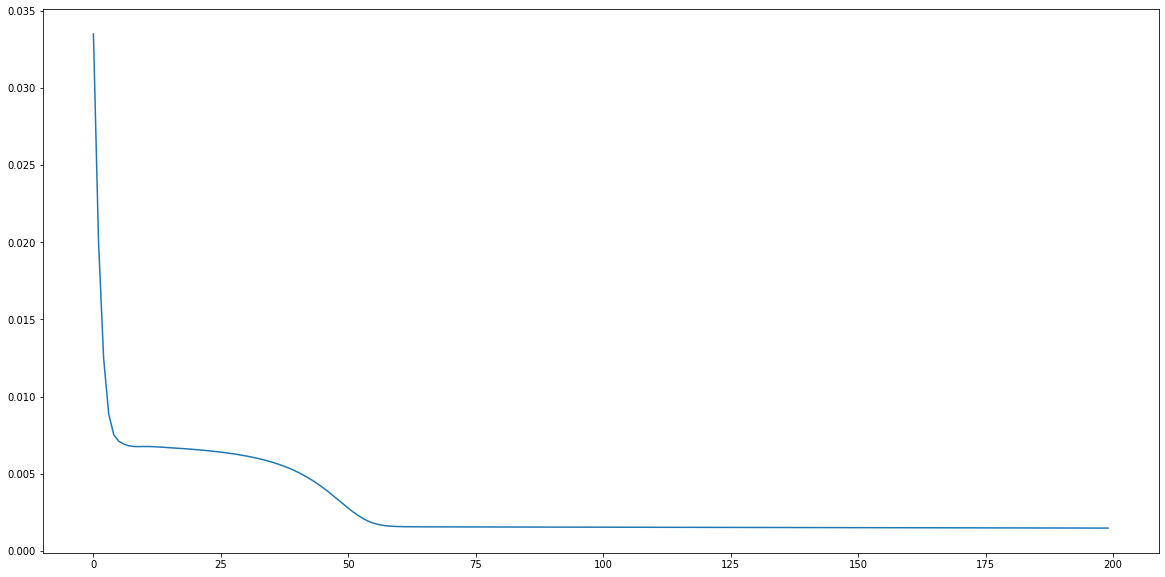

In [81]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

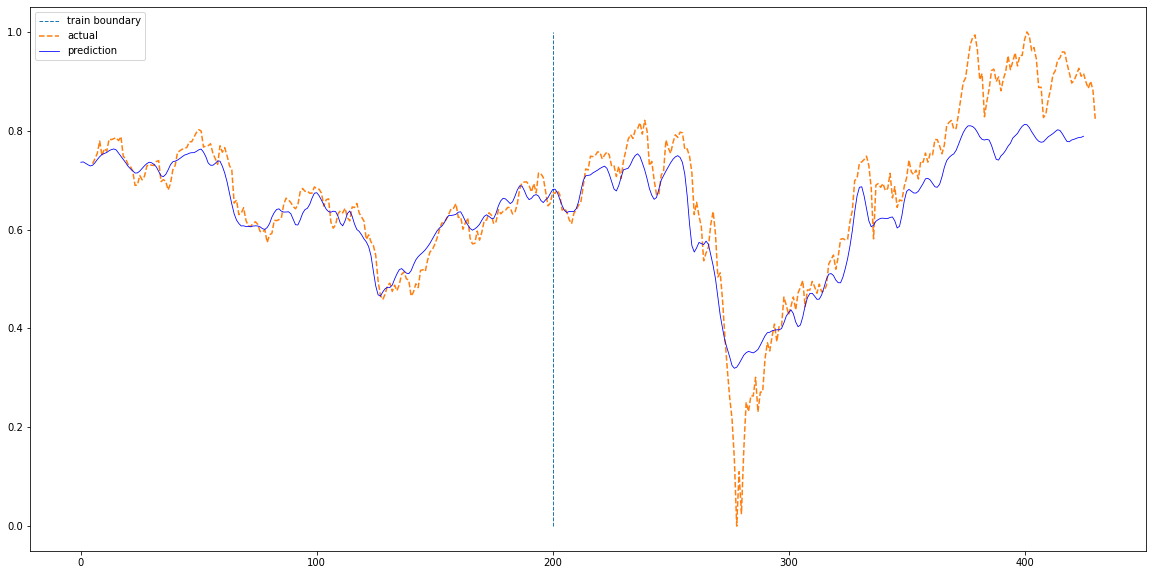

In [86]:
def plotting(train_loader, test_loader, actual):
  with torch.no_grad():
    train_pred = []
    test_pred = []

    for data in train_loader:
      seq, target = data
      out = model(seq)
      train_pred += out.cpu().numpy().tolist()

    for data in test_loader:
      seq, target = data
      out = model(seq)
      test_pred += out.cpu().numpy().tolist()
    
    total = train_pred+test_pred
    plt.figure(figsize=(20,10))
    plt.plot(np.ones(100)*len(train_pred),np.linspace(0, 1, 100), '--', linewidth=1)
    plt.plot(actual,'--')
    plt.plot(total,'b',linewidth=0.8)

    plt.legend(['train boundary', 'actual', 'prediction'])
    plt.show()
  
plotting(train_loader, test_loader, df['Close'][sequense_length:])